In [1]:
#load up the basics
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import TF stuff
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.9.1
 GPU: /device:GPU:0


In [2]:
#Load in DF
doodlecsvpath = '../data/Preds.csv'
doodlecsv = pd.read_csv(doodlecsvpath)
doodlecsv.head()

,Unnamed: 0,doodled_image,imageP,image,Filename,storm_id,archive,date,ul_lat,ul_lon,...,doodled_only_once,doodled_image_path,doodled_label_path,DiceLoss,mDice,mIoU,IoU_c1,IoU_c2,IoU_c3,IoU_c4
0,0,S21767202-1_Manish Shah.jpg,S21767202-1.jpg,S21767202.jpg,Isaias/20200804a_jpgs/jpgs/S21767202.jpg,isaias,20200804a_jpgs,2020-08-04,34.775966,-76.410598,...,True,../data/images/S21767202-1_Manish Shah.jpg,../data/labels/S21767202-1_Manish Shah_label.jpg,0.355374,0.644626,0.565756,0.750846,0.748771,0.761955,0.001452
1,1,P26157479-0_db.jpg,P26157479-0.jpg,P26157479.jpg,Florence/20180918a_jpgs/jpgs/P26157479.jpg,florence,20180918a_jpgs,2018-09-18,33.906110,-78.390211,...,True,../data/images/P26157479-0_db.jpg,../data/labels/P26157479-0_db_label.jpg,0.197519,0.802481,0.687306,0.949200,0.698310,0.561332,0.540384
2,2,P26157648-0_db.jpg,P26157648-0.jpg,P26157648.jpg,Florence/20180918a_jpgs/jpgs/P26157648.jpg,florence,20180918a_jpgs,2018-09-18,33.923909,-78.229009,...,True,../data/images/P26157648-0_db.jpg,../data/labels/P26157648-0_db_label.jpg,0.386702,0.613298,0.533556,0.878960,0.307724,0.890821,0.056717
3,3,P28460585-1_SF.jpg,P28460585-1.jpg,P28460585.jpg,Michael/20181011a_jpgs/jpgs/P28460585.jpg,michael,20181011a_jpgs,2018-10-11,30.363916,-86.269182,...,True,../data/images/P28460585-1_SF.jpg,../data/labels/P28460585-1_SF_label.jpg,0.130847,0.869153,0.771531,0.826177,0.715110,0.832978,0.711861
4,4,P26157388-0_JJF.jpg,P26157388-0.jpg,P26157388.jpg,Florence/20180918a_jpgs/jpgs/P26157388.jpg,florence,20180918a_jpgs,2018-09-18,33.878152,-78.493664,...,True,../data/images/P26157388-0_JJF.jpg,../data/labels/P26157388-0_JJF_label.jpg,0.177504,0.822496,0.715360,0.722921,0.748157,0.898927,0.491436


In [3]:
p_columns = ["mDice", "mIoU", "IoU_c1",
"IoU_c2","IoU_c3", "IoU_c4"]

In [4]:
#Load up the TF model

#model path
model_path = '../model/NOAA_NewLoss_fullmodel_model'

# load model into tf
model_base = tf.keras.models.load_model(model_path, compile = True)


model_base.trainable = False


In [5]:
# standardization using adjusted standard deviation, as required by Gym model

def standardize(img):

    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0 / np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    del m, s, N
    #
    if np.ndim(img) == 2:
        img = np.dstack((img, img, img))

    return img

In [6]:
model_base.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1024,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 768, 1024, 4  52          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 768, 1024, 4  16         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                )                                                                 
                                                                                                  
 activation_7 (Activation)      (None, 192, 256, 16  0           ['batch_normalization_7[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 192, 256, 16  20752       ['activation_6[0][0]']           
                                )                                                                 
                                                                                                  
 add_2 (Add)                    (None, 192, 256, 16  0           ['activation_7[0][0]',           
                                )                                 'conv2d_7[0][0]']               
          

 activation_15 (Activation)     (None, 48, 64, 64)   0           ['batch_normalization_15[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 48, 64, 64)   331840      ['activation_15[0][0]']          
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 96, 128, 64)  0           ['conv2d_16[0][0]']              
                                                                                                  
 concatenate (Concatenate)      (None, 96, 128, 96)  0           ['up_sampling2d[0][0]',          
                                                                  'add_3[0][0]']                  
                                                                                                  
 batch_normalization_16 (BatchN  (None, 96, 128, 96)  384        ['concatenate[0][0]']            
 ormalizat

                                                                                                  
 conv2d_25 (Conv2D)             (None, 384, 512, 16  656         ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_23 (BatchN  (None, 384, 512, 16  64         ['conv2d_23[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 batch_normalization_24 (BatchN  (None, 384, 512, 16  64         ['conv2d_25[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activatio

In [7]:
x = model_base.get_layer('activation_12').output

# add avg pool
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a dense Layer
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5, name='drd1')(x)
# Add a dense Layer
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5, name='drd2')(x)
# Add a final linear layer for classification
x = tf.keras.layers.Dense(len(p_columns), activation='relu')(x) 


model = tf.keras.Model(model_base.input, x) 

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1024,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 768, 1024, 4  52          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 768, 1024, 4  16         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                )                                                                 
                                                                                                  
 activation_7 (Activation)      (None, 192, 256, 16  0           ['batch_normalization_7[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 192, 256, 16  20752       ['activation_6[0][0]']           
                                )                                                                 
                                                                                                  
 add_2 (Add)                    (None, 192, 256, 16  0           ['activation_7[0][0]',           
                                )                                 'conv2d_7[0][0]']               
          

In [8]:
#build data generators for training and validaton

#split is 70/20/10 for 300 images, so XX 210 image, 60 images, 30 images.. 
#the 30 have been removed for testing already, so its 22.23% of teh remaining images as validation
split = 0.2


# Add our data-augmentation parameters to ImageDataGenerator and split data
datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'reflect',
    preprocessing_function = standardize,
    validation_split = split)

val_datagen = ImageDataGenerator(preprocessing_function = standardize, validation_split = split)


#set batch Size
batch_size = 8

#set color
# c_ch = 1
# c_mode = 'grayscale'
c_ch = 3

#set Image size (RGB so imshape is 3)
imsize = (768, 1024) 
imshape = (768, 1024, 3)

# Flow training images in batches 
train_generator = datagen.flow_from_dataframe(dataframe = doodlecsv,
                                                    directory = "",
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'doodled_image_path',
                                                    y_col = p_columns,
                                                    target_size = imsize,
                                                    color_mode = 'rgb',
                                                    seed = 11,
                                                    shuffle=False,
                                                    subset ='training')

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_dataframe(dataframe=doodlecsv,
                                                          directory = "",
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'doodled_image_path',
                                                          y_col = p_columns,
                                                          target_size = imsize,
                                                          color_mode = 'rgb',
                                                          seed = 11,
                                                          shuffle=False,
                                                          subset ='validation')

Found 840 validated image filenames.
Found 210 validated image filenames.


In [9]:
# define other metrics
MAE = tf.keras.metrics.MeanAbsoluteError(name='mae')

In [10]:
#compile the model
model.compile(loss = tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4), 
              metrics = [MAE]
             )

In [11]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 40, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.2,
                                                 verbose = 1,
                                                 patience = 5)



In [12]:
#train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 200,
                    workers = 8,
                    callbacks =[early_stop, reduce_lr])


Epoch 1/200
105/105 [==============================] - 13s 92ms/step - loss: 0.2094 - mae: 0.3103 - val_loss: 0.1208 - val_mae: 0.2077 - lr: 1.0000e-04
Epoch 2/200
105/105 [==============================] - 9s 86ms/step - loss: 0.1486 - mae: 0.2460 - val_loss: 0.1074 - val_mae: 0.1844 - lr: 1.0000e-04
Epoch 3/200
105/105 [==============================] - 9s 86ms/step - loss: 0.1323 - mae: 0.2271 - val_loss: 0.1022 - val_mae: 0.1818 - lr: 1.0000e-04
Epoch 4/200
105/105 [==============================] - 9s 86ms/step - loss: 0.1224 - mae: 0.2140 - val_loss: 0.0985 - val_mae: 0.1724 - lr: 1.0000e-04
Epoch 5/200
105/105 [==============================] - 9s 87ms/step - loss: 0.1157 - mae: 0.2054 - val_loss: 0.0959 - val_mae: 0.1747 - lr: 1.0000e-04
Epoch 6/200
105/105 [==============================] - 9s 86ms/step - loss: 0.1105 - mae: 0.2005 - val_loss: 0.0957 - val_mae: 0.1717 - lr: 1.0000e-04
Epoch 7/200
105/105 [==============================] - 9s 85ms/step - loss: 0.1084 - mae: 0.1

Epoch 55/200
105/105 [==============================] - 9s 89ms/step - loss: 0.0591 - mae: 0.1406 - val_loss: 0.0645 - val_mae: 0.1437 - lr: 1.0000e-04
Epoch 56/200
105/105 [==============================] - 9s 89ms/step - loss: 0.0595 - mae: 0.1413 - val_loss: 0.0644 - val_mae: 0.1446 - lr: 1.0000e-04
Epoch 57/200
105/105 [==============================] - 10s 89ms/step - loss: 0.0574 - mae: 0.1383 - val_loss: 0.0627 - val_mae: 0.1423 - lr: 1.0000e-04
Epoch 58/200
105/105 [==============================] - 10s 90ms/step - loss: 0.0587 - mae: 0.1411 - val_loss: 0.0651 - val_mae: 0.1473 - lr: 1.0000e-04
Epoch 59/200
105/105 [==============================] - 9s 89ms/step - loss: 0.0577 - mae: 0.1400 - val_loss: 0.0607 - val_mae: 0.1385 - lr: 1.0000e-04
Epoch 60/200
105/105 [==============================] - 10s 89ms/step - loss: 0.0566 - mae: 0.1377 - val_loss: 0.0611 - val_mae: 0.1403 - lr: 1.0000e-04
Epoch 61/200
105/105 [==============================] - 10s 90ms/step - loss: 0.0559 

105/105 [==============================] - 9s 88ms/step - loss: 0.0479 - mae: 0.1270 - val_loss: 0.0560 - val_mae: 0.1375 - lr: 3.2000e-08
Epoch 104/200
105/105 [==============================] - 9s 88ms/step - loss: 0.0470 - mae: 0.1243 - val_loss: 0.0560 - val_mae: 0.1375 - lr: 3.2000e-08
Epoch 105/200
105/105 [==============================] - ETA: 0s - loss: 0.0472 - mae: 0.1255
Epoch 105: ReduceLROnPlateau reducing learning rate to 6.399999818995639e-09.
105/105 [==============================] - 9s 88ms/step - loss: 0.0472 - mae: 0.1255 - val_loss: 0.0560 - val_mae: 0.1375 - lr: 3.2000e-08
Epoch 106/200
105/105 [==============================] - 9s 88ms/step - loss: 0.0469 - mae: 0.1247 - val_loss: 0.0560 - val_mae: 0.1375 - lr: 6.4000e-09
Epoch 107/200
105/105 [==============================] - 9s 88ms/step - loss: 0.0465 - mae: 0.1246 - val_loss: 0.0560 - val_mae: 0.1375 - lr: 6.4000e-09
Epoch 108/200
105/105 [==============================] - 9s 88ms/step - loss: 0.0470 - mae:

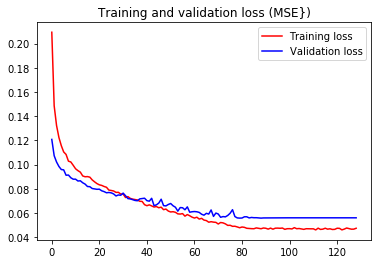

<Figure size 432x288 with 0 Axes>

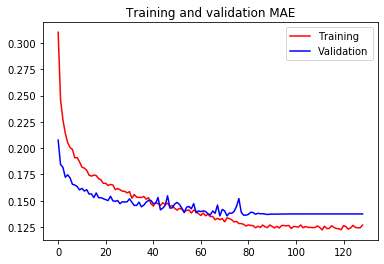

<Figure size 432x288 with 0 Axes>

In [14]:
#look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.ylim(0,70)

plt.title('Training and validation loss (MSE})')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs, mae, 'r', label='Training')
plt.plot(epochs, val_mae, 'b', label='Validation')
#plt.ylim(0,1)

plt.title('Training and validation MAE')
plt.legend(loc=0)
plt.figure()
plt.show()


In [15]:
#save the model
filepath = './model/PredictIoU'
model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)

INFO:tensorflow:Assets written to: ./model/PredictIoU/assets


INFO:tensorflow:Assets written to: ./model/PredictIoU/assets
